# Open-LLAMA 7B implementation using LMI container on SageMaker
### Model source: https://github.com/openlm-research/open_llama ; 
#### Model download hub: https://huggingface.co/openlm-research/open_llama_7b; 
#### License: Apache-2.0
In this tutorial, you will bring your own container from docker hub to SageMaker and run inference with it.
Please make sure the following permission granted before running the notebook:

- ECR Push/Pull access
- S3 bucket push access
- SageMaker access

#### Attribution: this notebook is based on the content of https://github.com/deepjavalibrary/djl-demo/tree/master and was debugged with the help of lanking520.

## Step 1: Let's bump up SageMaker and import stuff

In [1]:
%pip install --upgrade pip --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install sagemaker boto3 awscli --upgrade --quiet

In [3]:
import boto3
import sagemaker
from sagemaker import Model, serializers, deserializers

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()  # account_id of the current SageMaker Studio environment

In [4]:
print(role, region, account_id)

arn:aws:iam::328296961357:role/service-role/AmazonSageMaker-ExecutionRole-20191125T182032 us-west-2 328296961357


In [5]:
sagemaker.__version__

'2.161.0'

## Step 2 pull and push the docker from Docker hub to ECR repository (optional)
*Note: you can either use a prebuilt container or use the cell below (change cell type to 'code' from 'raw")

*Note: Please make sure you have the permission in AWS credential to push to ECR repository*

This process may take a while, depends on the container size and your network bandwidth
### Note: you only need to build this container once. Once you pushed it in ECR, you can pull the image via  
image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{repo_name}:latest"

## Step 3: Start preparing model artifacts
In LMI container, we expect some artifacts to help set up the model
- serving.properties (required): Defines the model server settings
- model.py (optional): A python file to define the core inference logic
- requirements.txt (optional): Any additional pip wheel need to install

In [7]:
%%writefile serving.properties
engine = Python
option.tensor_parallel_degree = 1
option.model_id = openlm-research/open_llama_7b

Writing serving.properties


In [8]:
%%writefile model.py
from djl_python import Input, Output
from djl_python.streaming_utils import StreamingUtils
import os
import deepspeed
import torch
import logging
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from transformers.models.llama.modeling_llama import LlamaDecoderLayer

##
from transformers import LlamaTokenizer, LlamaForCausalLM

model = None
tokenizer = None


def get_model(properties):
    model_name = properties["model_id"]
    tensor_parallel_degree = properties["tensor_parallel_degree"]
    max_tokens = int(properties.get("max_tokens", "1024"))
    dtype = torch.float16

    model = LlamaForCausalLM.from_pretrained(
        model_name, low_cpu_mem_usage=True, torch_dtype=dtype, device_map="auto"
    )
    tokenizer = LlamaTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer


def inference(inputs):
    try:
        input_map = inputs.get_as_json()
        data = input_map.pop("inputs", input_map)
        parameters = input_map.pop("parameters", {})
        outputs = Output()

        enable_streaming = (
            inputs.get_properties().get("enable_streaming", "false").lower() == "true"
        )
        if enable_streaming:
            stream_generator = StreamingUtils.get_stream_generator("DeepSpeed")
            outputs.add_stream_content(stream_generator(model, tokenizer, data, **parameters))
            return outputs

        tokenizer.add_special_tokens({"pad_token": "[PAD]"})
        tokenizer.padding_side = "left"
        input_tokens = tokenizer(data, padding=True, return_tensors="pt").to(
            torch.cuda.current_device()
        )
        with torch.no_grad():
            output_tokens = model.generate(input_tokens.input_ids, **parameters)
        generated_text = tokenizer.batch_decode(output_tokens, skip_special_tokens=True)

        outputs.add_as_json([{"generated_text": s} for s in generated_text])
        return outputs
    except Exception as e:
        logging.exception("Huggingface inference failed")
        # error handling
        outputs = Output().error(str(e))


def handle(inputs: Input) -> None:
    global model, tokenizer
    if not model:
        model, tokenizer = get_model(inputs.get_properties())

    if inputs.is_empty():
        # Model server makes an empty call to warmup the model on startup
        return None

    return inference(inputs)

Writing model.py


In [9]:
%%writefile requirements.txt
transformers==4.28.1
protobuf==3.20.1

Writing requirements.txt


In [10]:
%%sh
mkdir mymodel
mv serving.properties mymodel/
mv model.py mymodel/
mv requirements.txt mymodel/
tar czvf mymodel.tar.gz mymodel/
rm -rf mymodel

mymodel/
mymodel/requirements.txt
mymodel/model.py
mymodel/serving.properties


## Step 4: Start building SageMaker endpoint
In this step, we will build SageMaker endpoint from scratch

### 4.1 Upload artifact on S3 and create SageMaker model

In [12]:
s3_code_prefix = "large-model-lmi/code"
default_bucket_prefix = sess.default_bucket_prefix

# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    s3_code_prefix = f"{default_bucket_prefix}/{s3_code_prefix}"

bucket = sess.default_bucket()  # bucket to house artifacts
code_artifact = sess.upload_data("mymodel.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact}")

# repo_name="djlserving-byoc"
# image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{repo_name}:latest"
image_uri = sagemaker.image_uris.retrieve(
    framework="djl-deepspeed", region=region, version="0.23.0"
)


print(image_uri)

model = Model(image_uri=image_uri, model_data=code_artifact, role=role)

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-328296961357/large-model-lmi/code/mymodel.tar.gz
763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


### 4.2 Create SageMaker endpoint

You need to specify the instance to use and endpoint names

In [13]:
instance_type = "ml.g5.2xlarge"  # "ml.g5.2xlarge" - #single GPU. really need one GPU for this since tensor split is '1'

endpoint_name = sagemaker.utils.name_from_base("open-llama-lmi-model")

model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name,
    container_startup_health_check_timeout=900,
)

# our requests and responses will be in json format so we specify the serializer and the deserializer
predictor = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=deserializers.JSONDeserializer(),
)

--------------!

## Step 5a: Test and benchmark inference latency
### The latency is heavily dependent on 'max_new_tokens' parameter

In [14]:
import time

tic = time.time()
predictor.predict(
    {"inputs": "tuna sandwich nutritional content is ", "parameters": {"max_new_tokens": 16}}
)
toc = time.time()
print(toc - tic)

2.2340340614318848


## Let us define a helper function to get a histogram of invocation latency distribution

In [15]:
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm


def _latency_hist_plot(endpoint_name, invocation_number=100, sleep_time=1):
    latency_array = []
    for i in tqdm(range(invocation_number)):
        tic = time.time()
        response_ = predictor.predict(
            {"inputs": "Large model inference is", "parameters": {"max_new_tokens": 256}}
        )
        toc = time.time()
        latency_array.append(toc - tic)
        time.sleep(sleep_time)

    latency_array_np = np.array(latency_array)
    _ = plt.hist(latency_array_np, bins="auto")  # arguments are passed to np.histogram
    plt.title("Invocation Latency Histogram with 'auto' bins")
    plt.show()

Matplotlib is building the font cache; this may take a moment.


100%|██████████| 10/10 [01:53<00:00, 11.35s/it]


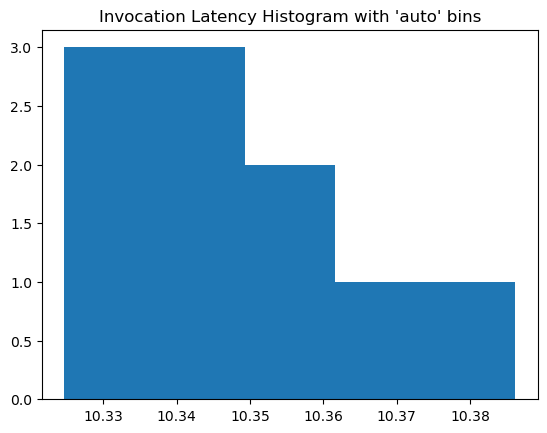

114.2704861164093
CPU times: user 258 ms, sys: 39.5 ms, total: 298 ms
Wall time: 1min 54s


In [16]:
%%time
inv_start_time = time.time()
invocation_number = 10
# Real-time endpoint
_latency_hist_plot(endpoint_name, invocation_number, sleep_time=1)
inv_lapse_time = time.time() - inv_start_time
print(inv_lapse_time)

In [17]:
endpoint_name = predictor.endpoint_name
print(endpoint_name)
print(region)

open-llama-lmi-model-2023-06-02-00-16-24-723
us-west-2


## Step 5b: Analyze Inference Latency via CloudWatch

In [18]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-test-endpoints.html
import pandas as pd

cw = boto3.client("cloudwatch", region_name=region)


def get_invocation_metrics_for_endpoint(endpoint_name, metric_name, start_time, end_time):
    #     metric = "Sum"
    metric = "Average"
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=1,
        Statistics=[metric],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": "AllTraffic"},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={metric: metric_name})
    )


#     return metrics

In [19]:
import datetime


def plot_endpoint_metrics(start_time=None, end_time=None):
    #    start_time = start_time or datetime.datetime.now() - datetime.timedelta(seconds=inv_lapse_time+60)
    #    end_time = datetime.datetime.now()
    model_metrics = get_invocation_metrics_for_endpoint(
        endpoint_name, "ModelLatency", start_time, end_time
    )
    overhead_metrics = get_invocation_metrics_for_endpoint(
        endpoint_name, "OverheadLatency", start_time, end_time
    )
    total_metrics = model_metrics.join(overhead_metrics)
    total_metrics["ModelLatency"] = total_metrics["ModelLatency"] / 1000
    total_metrics["OverheadLatency"] = total_metrics["OverheadLatency"] / 1000
    #    total_metrics["TotalLatency in ms"] = total_metrics[["ModelLatency","OverheadLatency"]].sum(axis=1)
    #     total_metrics = total_metrics.drop(['ModelLatency', 'OverheadLatency'], axis=1)
    total_metrics.plot()
    return total_metrics

In [20]:
endtime = datetime.datetime.now()
print(endtime)
startime = endtime - datetime.timedelta(seconds=inv_lapse_time + 60)
print(startime)

2023-06-02 00:26:07.841647
2023-06-02 00:23:13.571161


In [21]:
# wait for cloudwatch metrics to populate
time.sleep(300)

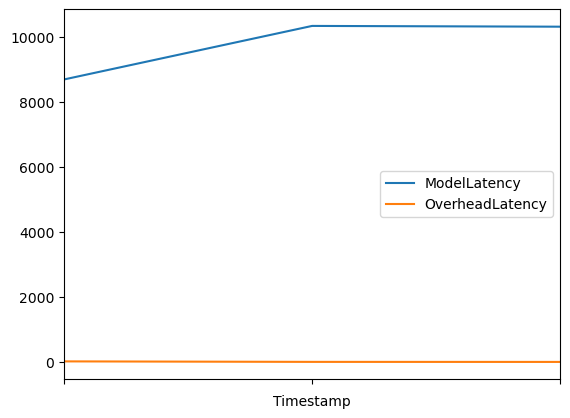

In [22]:
total_metrics = plot_endpoint_metrics(start_time=startime, end_time=endtime)
# total_metrics = plot_endpoint_metrics(start_time=startime, end_time=endtime)

In [23]:
# Latency expressed in ms
total_metrics

,ModelLatency,OverheadLatency
Timestamp,,
2023-06-02 00:24:00+00:00,8692.3982,22.5878
2023-06-02 00:25:00+00:00,10338.1598,7.3332
2023-06-02 00:26:00+00:00,10314.6550,5.9240


## Clean up the environment

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
model.delete_model()